In [57]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

In [58]:
train_path = 'dataset/Preprocessed_2DSS/training/coco'
val_path = 'dataset/Preprocessed_2DSS/validation/coco'
test_path = 'dataset/Preprocessed_2DSS/test/coco'

train_json_path = os.path.join(train_path, 'training_coco.json')
val_json_path = os.path.join(val_path, 'validation_coco.json')
test_json_path = os.path.join(test_path, 'test_coco.json')

register_coco_instances("2DSS_train", {}, train_json_path, train_path)
register_coco_instances("2DSS_val", {}, val_json_path, val_path)
register_coco_instances("2DSS_test", {}, test_json_path, test_path)

In [59]:
cfg = get_cfg()
cfg.merge_from_file(cfg.OUTPUT_DIR+'/config.yaml')

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0044999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

Loading config ./output/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.



Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



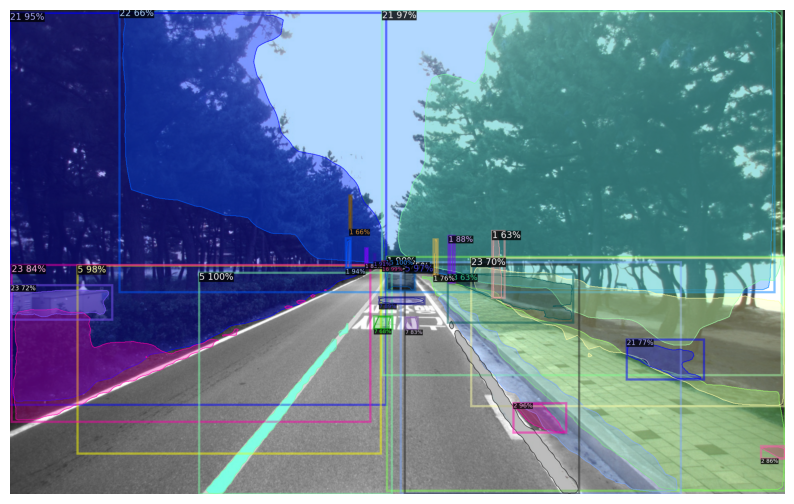

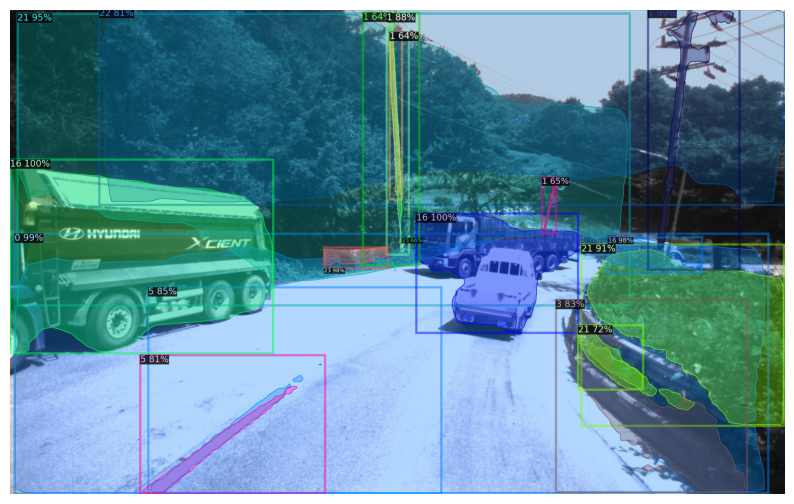

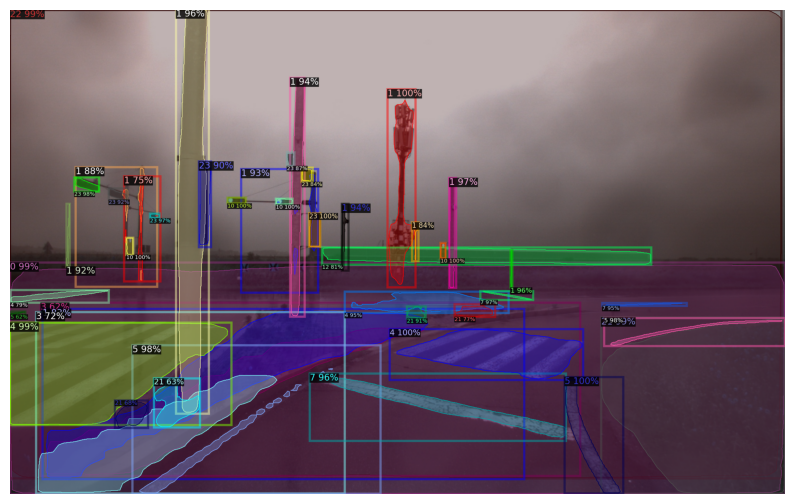

: 

In [60]:
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
dataset_dicts = DatasetCatalog.get(cfg.DATASETS.TEST[0])

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
        metadata=metadata, 
        scale=1.5, 
        instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.figure(figsize=(10,10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

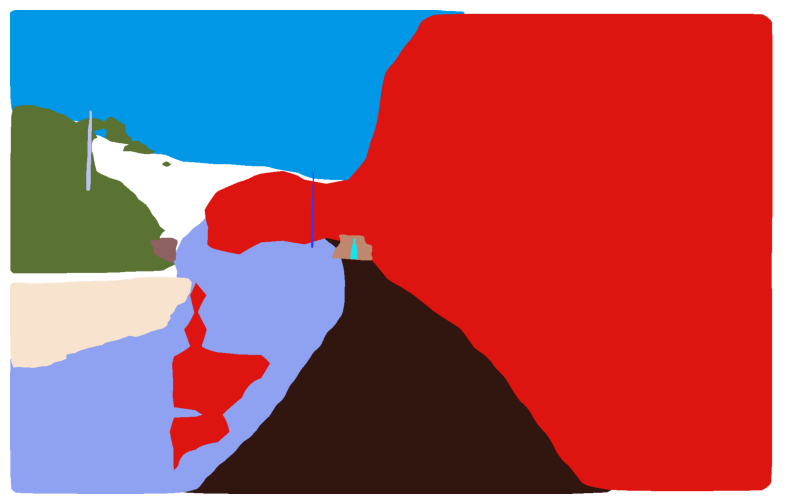

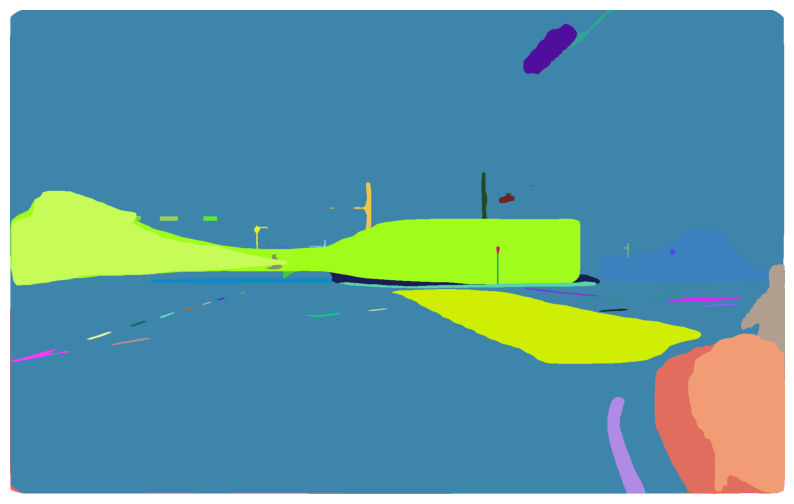

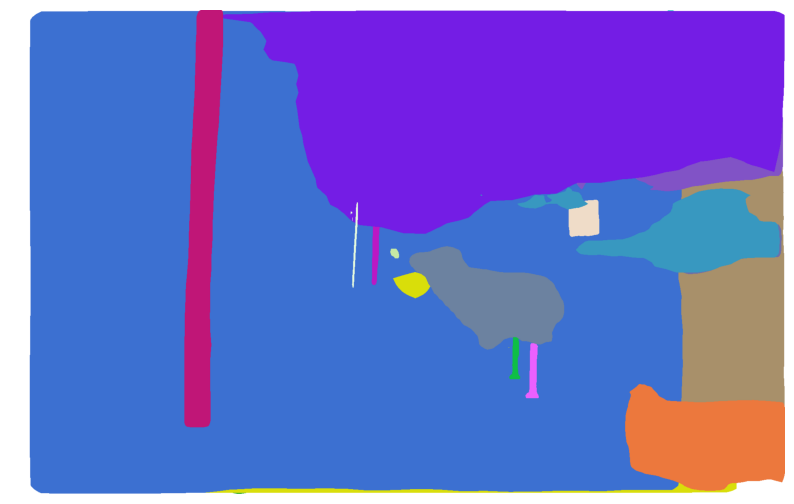

In [55]:
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
        metadata=metadata, 
        scale=1.5, 
        instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    masks = outputs["instances"].pred_masks.to("cpu").numpy()
    classes = outputs["instances"].pred_classes.to("cpu").numpy()
    im[:] = 255

    for i in range(len(masks)):
        mask = masks[i]
        color = np.random.rand(3)
        #im[mask] = im[mask] * 0.5 + color * 255 * 0.5
        im[mask] = color * 255
        
    plt.figure(figsize=(10,10))
    plt.imshow(im[:, :, ::-1])
    plt.axis('off')
    plt.show()